# Gemma2 Model Fine Tuning Guide for SQL Auxiliary agent

## Set-up

In [ ]:
# Install package
# !pip install -U "transformers>=4.42.3" bitsandbytes accelerate peft
# !pip install -q -U trl
# !pip install -q -U datasets

In [ ]:
# Import package
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset, Dataset
import pandas as pd
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType, PeftModel
import bitsandbytes as bnb
from trl import SFTTrainer
from transformers import TrainingArguments
from huggingface_hub import login
import wandb
import transformers

In [ ]:
# Log in to Hugging Face 
login('') # your token 

## Model

In [ ]:
# Quantize to 4 bits
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16

)

In [ ]:
# Load Gemma
model_id = "google/gemma-2-9b-it"
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config = bnb_config, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)

## Data Loading
- https://huggingface.co/datasets/gretelai/synthetic_text_to_sql

In [ ]:
splits = {'train': 'synthetic_text_to_sql_train.snappy.parquet', 'test': 'synthetic_text_to_sql_test.snappy.parquet'}
df = pd.read_parquet("hf://datasets/gretelai/synthetic_text_to_sql/" + splits["train"])
valid = pd.read_parquet("hf://datasets/gretelai/synthetic_text_to_sql/" + splits["test"])

In [ ]:
data = df[['sql_prompt','sql_context','sql']] # train
valid = valid[['sql_prompt','sql_context','sql']] # validation

In [ ]:
guide = '''
    You are a MySQL expert. Your job is to answer questions about a database. You are given a question and context regarding one or more tables.
    
    You must output the SQL query that answers the question.
    
    Let me give you some precautions:

    1. Return ONLY the generated SQL query and nothing else.

    2. Do not use or add any information outside of the context provided.

    3. Pay close attention to which column belongs to which table. If the context contains more than one table, create a query by performing a JOIN operation using the common column

    4. Ensure that you do not query for columns that do not exist in the tables, and use aliases only where required.

    5. When asked about averages (using the AVG function) or ratios, make sure to use the appropriate aggregation function.

    6. Pay close attention to the filtering criteria mentioned in the question and incorporate them using the WHERE clause in your SQL query.

    7. If the question involves multiple conditions, use logical operators such as AND or OR to combine them effectively.

    8. When dealing with date or timestamp columns, use appropriate date functions (e.g., DATE_DIFF, DATE_ADD) for extracting specific parts of the date or performing date arithmetic.

    9. If the question involves grouping of data (e.g., finding totals or averages for different categories), use the GROUP BY clause along with appropriate aggregate functions.

    10. Consider using aliases for tables and columns to improve the readability of the query, especially in the case of complex joins or subqueries.
    
    Additional guidelines :
    
    - Use LIMIT to restrict the number of returned rows when the question asks for a limited number of results or pagination.

    - Use DISTINCT to remove duplicates if the question requests unique values.

    - Use ORDER BY to sort the results in ascending (ASC) or descending (DESC) order, as specified in the question.

    - Handle NULL values appropriately. Use IS NULL or IS NOT NULL to filter out or include NULL values, and use the COALESCE function when needed to replace NULLs.

    - Use HAVING instead of WHERE when filtering aggregated data.

    - Use the CASE statement for conditional logic to return different values based on specific conditions.

    - Leverage subqueries when the question is complex and requires filtering or extracting data from nested queries.

    - Use database-specific functions like STR_TO_DATE() in MySQL or TO_CHAR() in PostgreSQL when appropriate.

    - Optimize JOIN performance by ensuring unnecessary data is filtered in the WHERE clause and considering the order of JOINs for efficiency.

    - Use ROUND() or similar functions for numeric accuracy when handling decimals or rounding values.

    - Interpret vague questions to produce logical queries, such as converting "top few items" into a specific number like "top 5" based on context.

'''

#### When learning without guidelines, DDL was used. To prevent this, I created some guidelines and injected them into the prompt to learn them, which seems to have improved slightly. 

#### I think the results would be better if the guidelines were more specific or provided with examples!

## Testing

In [ ]:
# Define 
def eval_com(query : str, context : str, guide : str, model, tokenizer, max_tokens=1000) -> str:
    device = "cuda:0"


    prompt_tem = '''
    <bos><start_of_turn>user
    {guide}
    
    context: {context}

    question: {query}

    <end_of_turn>
    <start_of_turn>model
    '''


    prompt = prompt_tem.format(query=query, context = context, guide = guide)

    encoders = tokenizer(prompt, return_tensors="pt",add_special_tokens=True)

    model_inputs = encoders.to(device)

    generated_ids = model.generate(
      **model_inputs,
      max_new_tokens=max_tokens,
      do_sample=True)
      # pad_token_id=tokenizer.eos.token_id)

    decode = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return (decode)

In [ ]:
result = eval_com(query = valid['sql_prompt'][0], context =valid['sql_context'][0], guide = guide, model=model,tokenizer=tokenizer)
print(result)

In [ ]:
valid['sql'][0]

#### Nice!

## Train

In [ ]:
train = data
valid = valid

In [ ]:
train

In [ ]:
def generate_prompt(data_point,guide=guide):
    tem = '''
    <bos><start_of_turn>user
    {guide}

    context: {sql_context}

    question: {sql_prompt}

    <end_of_turn>
    <start_of_turn>model
    {sql}
    '''
    return tem.format(guide = guide,
      sql_context=data_point["sql_context"],
      sql_prompt=data_point["sql_prompt"],
      sql=data_point["sql"],
    )

def generate_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenizer(full_prompt)
    return tokenized_full_prompt

In [ ]:
train = Dataset.from_pandas(train)

In [ ]:
valid = Dataset.from_pandas(valid)

In [ ]:
valid_dataset = valid.add_column("prompt", [generate_prompt(d) for d in valid])
valid_dataset

In [ ]:
train_dataset = train.add_column("prompt", [generate_prompt(d) for d in train])
train_dataset

In [ ]:
train_dataset = train_dataset.map(lambda x: tokenizer(x["prompt"]), batched=True)
train_dataset

In [ ]:
valid_dataset = valid_dataset.map(lambda x: tokenizer(x["prompt"]), batched=True)
valid_dataset

In [ ]:
model.gradient_checkpointing_enable()
model=prepare_model_for_kbit_training(model)

In [ ]:
print(model)

In [ ]:
def find_all_lenear_name(model):
    cls = bnb.nn.Linear4bit
    lora_module = set()

    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module.add(names[0] if len(names)==1 else names[-1])
        if 'lm_head' in lora_module:
            lora_module.remove('lm_head')
    return list(lora_module)

In [ ]:
modules = find_all_lenear_name(model)
print(modules)

In [ ]:
new_model = "SEUNGYEOPOH/SQL_Auxiliary_Agent_9B" #hub repo

In [ ]:
lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
torch.cuda.empty_cache

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    dataset_text_field="prompt",
    peft_config=lora_config,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=500,
        learning_rate=2e-4,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit",
        save_strategy="epoch",
        evaluation_strategy="epoch", 
        report_to="wandb"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)



#### To view the training process, assign the report_to parameter to wandb. During the training, you'll be prompted to enter an API key. 
#### At that point, if you enter your wandb API key, you'll be able to visualize the training process in the form of a report. 
#### The report for the model I trained is as follows

## Train Report

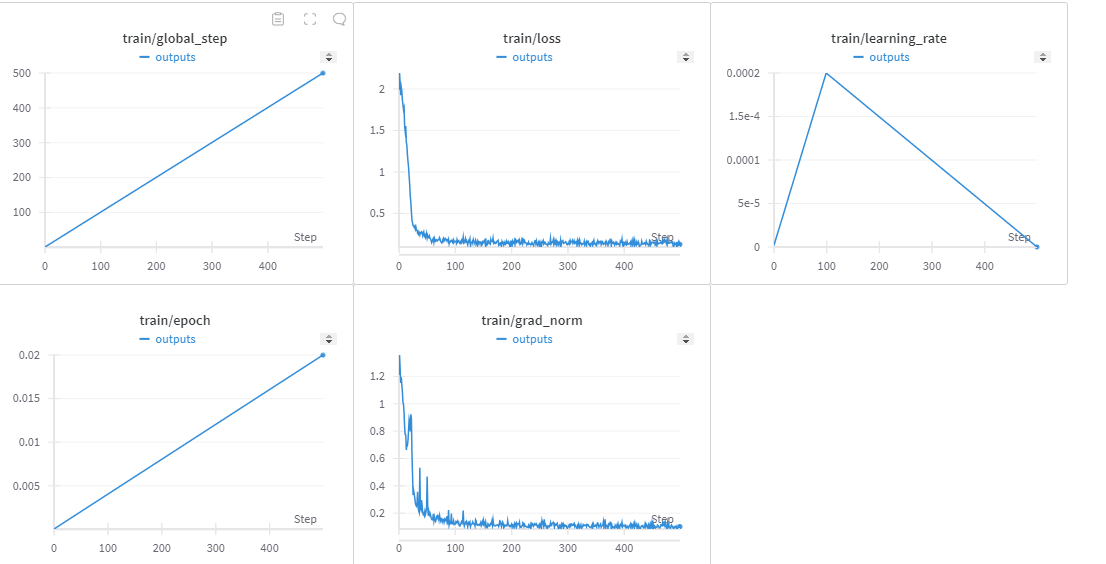

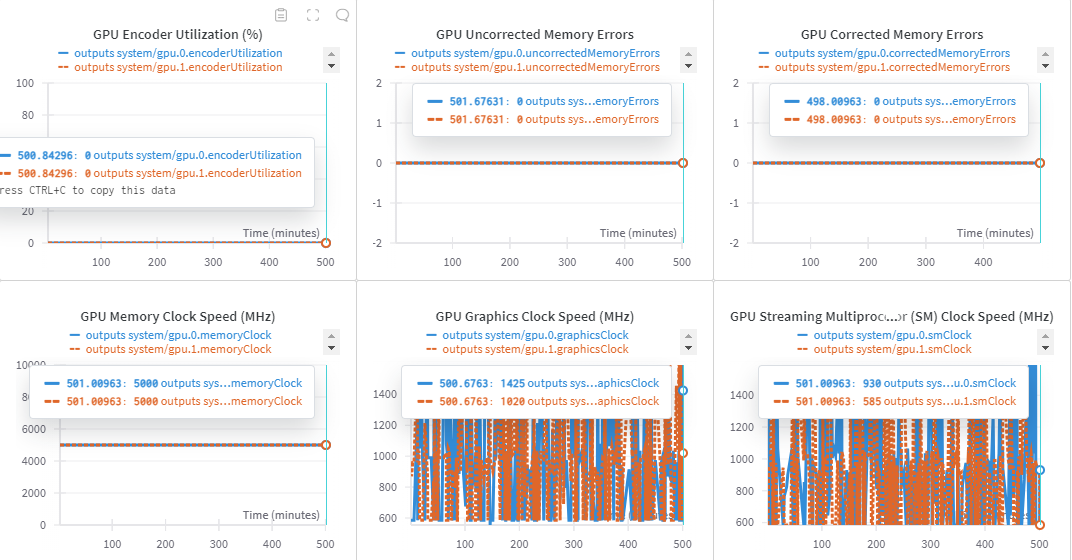

In [ ]:
model.config.use_cache = False
trainer.train()

In [ ]:
wandb.finish()
model.config.use_cache = True

In [ ]:
model

## push to hub

In [ ]:
new_model = "SQL_Auxiliary_Agent_9B"


trainer.model.save_pretrained(new_model)

tokenizer.save_pretrained(new_model)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

trainer.model.push_to_hub(new_model, use_temp_dir=False)
tokenizer.push_to_hub(new_model, use_temp_dir=False) 